In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Load the data

In [2]:
df = pd.read_csv(r"F:\Data_Science_Jupyter_Files\weatherAUS_2.csv")

In [3]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
df.count()

Date             145460
Location         145460
MinTemp          143975
MaxTemp          144199
Rainfall         142199
Evaporation       82670
Sunshine          75625
WindGustDir      135134
WindGustSpeed    135197
WindDir9am       134894
WindDir3pm       141232
WindSpeed9am     143693
WindSpeed3pm     142398
Humidity9am      142806
Humidity3pm      140953
Pressure9am      130395
Pressure3pm      130432
Cloud9am          89572
Cloud3pm          86102
Temp9am          143693
Temp3pm          141851
RainToday        142199
RainTomorrow     142193
dtype: int64

### Drop all rows with missing values

In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

In [6]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

If we adjust our approach and aim to predict today’s rainfall using historical weather data up to and including yesterday, then we can legitimately utilize all of the available features. This shift would be particularly useful for practical applications, such as deciding whether you will bike to work today.

With this new target, we should update the names of the rain columns accordingly to avoid confusion.

In [7]:
df = df.rename(columns={"RainToday":"RainYesterday", "RainTomorrow":"RainToday"})

### Data Granularity

Would the weather patterns have the same predictability in vastly different locations in Australia? I would think not.
The chance of rain in one location can be much higher than in another. Using all of the locations requires a more complex model as it needs to adapt to local weather patterns.
Let's see how many observations we have for each location, and see if we can reduce our attention to a smaller region.

### Location selection

You could do some research to group cities in the Location column by distance, which I've done for you behind the scenes.
I found that Watsonia is only 15 km from Melbourne, and the Melbourne Airport is only 18 km from Melbourne.
Let's group these three locations together and use only their weather data to build our localized prediction model.
Because there might still be some slight variations in the weather patterns we'll keep Location as a categorical variable.

In [8]:
df = df[df.Location.isin(["Melbourne", "MelbourneAirport","Watsonia"])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

We still have 7557 records, which should be enough to build a reasonably good model.
You could always gather more data if needed by partioning the data into similar locations or simplyby updating it from the source to include a larger time frame.

### Extracting a seasonality feature

Now consider the Date column. We expect the weather patterns to be seasonal, having different predictablitiy levels in winter and summer for example.
There may be some variation with Year as well, but we'll leave that out for now. Let's engineer a Season feature from Date and drop Date afterward, since it is most likely less informative than season. An easy way to do this is to define a function that assigns seasons to given months, then use that function to transform the Date column.

### Create a function to map dates to seasons

In [9]:
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return "Summer"
    if (month == 3) or (month == 4) or (month == 5):
        return "Autumn"
    if (month == 6) or (month == 7) or (month == 8):
        return "Winter"
    if (month == 9) or (month == 10) or (month == 11):
        return "Spring"

### Exercise 1: Map the dates to seasons and drop the Date column

In [10]:
# Convert the 'Date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Apply the function to the 'Date' column
df["Season"] = df["Date"].apply(date_to_season)

df = df.drop(columns="Date")
df

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainToday,Season
64191,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,W,SW,...,37.0,1005.1,1006.4,7.0,7.0,15.9,18.1,No,Yes,Summer
64192,MelbourneAirport,7.8,17.8,1.2,7.2,12.9,SSE,56.0,SW,SSE,...,43.0,1018.0,1019.3,6.0,7.0,12.5,15.8,Yes,No,Summer
64193,MelbourneAirport,6.3,21.1,0.0,6.2,10.5,SSE,31.0,E,S,...,35.0,1020.8,1017.6,1.0,7.0,13.4,19.6,No,No,Summer
64194,MelbourneAirport,8.1,29.2,0.0,6.4,12.5,SSE,35.0,NE,SSE,...,23.0,1016.2,1012.8,5.0,4.0,16.0,28.2,No,No,Summer
64195,MelbourneAirport,9.7,29.0,0.0,7.4,12.3,SE,33.0,SW,SSE,...,31.0,1011.9,1010.3,6.0,2.0,19.4,27.1,No,No,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80992,Watsonia,3.6,14.5,0.0,2.4,8.8,NNE,41.0,ENE,NNE,...,66.0,1028.4,1025.0,1.0,7.0,5.2,13.8,No,No,Winter
80994,Watsonia,4.8,13.3,0.4,0.6,0.0,NNW,24.0,NE,NNE,...,63.0,1028.5,1025.1,7.0,7.0,5.6,12.4,No,No,Winter
80995,Watsonia,5.6,13.1,0.0,1.6,6.0,NNW,52.0,NE,N,...,67.0,1019.0,1014.0,1.0,7.0,8.8,11.6,No,Yes,Winter
80996,Watsonia,6.9,12.1,3.2,1.8,5.6,SSW,24.0,WNW,SW,...,61.0,1018.7,1017.3,2.0,7.0,7.9,11.0,Yes,No,Winter


### Exercise 2. Define the feature and target dataframes

In [12]:
X = df.drop(columns="RainToday", axis=1)
y = df["RainToday"]

### Exercise 3. How balanced are the classes?

In [13]:
y.value_counts()

RainToday
No     5766
Yes    1791
Name: count, dtype: int64

### Exercise 5. Split data into training and test sets, ensuring target stratification

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Exercise 6. Automatically detect numerical and categorical columns and assign them to separate numeric and categorical features

In [21]:
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

#### Define separate transformers for both feature types and combine them into a single preprocessing transformer

In [22]:
# Scale the numeric features
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

# One-hot encode the categoricals 
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

### Exercise 7. Combine the transformers into a single preprocessing column transformer

In [25]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

### Exercise 8. Create a pipeline by combining the preprocessing with a Random Forest classifier

In [26]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

#### Define a parameter grid to use in a cross validation grid search model optimizer

In [30]:
param_grid = {
    "classifier__n_estimators": [50, 100],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5]
}

#### Perform grid search cross-validation and fit the best model to the training data

In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

### Exercise 9. Instantiate and fit GridSearchCV to the pipeline

In [32]:
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring="accuracy", verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   1.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   1.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   1.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   1.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   1.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   3.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.9s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pr...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainYesterday',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

#### Print the best parameters and best crossvalidation score

In [33]:
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.86


### Exercise 10. Display your model's estimated score

In [36]:
test_score = grid_search.score(X_test, y_test)
print(f"\nTest set score: {test_score:.2%}")


Test set score: 84.46%


### Exercise 11. Get the model predictions from the grid search estimator on the unseen data

In [37]:
y_pred = grid_search.predict(X_test)

### Exercise 12. Print the classification report

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.86      0.95      0.90      1154
         Yes       0.75      0.51      0.61       358

    accuracy                           0.84      1512
   macro avg       0.81      0.73      0.76      1512
weighted avg       0.84      0.84      0.83      1512



### Exercise 13. Plot the confusion matrix

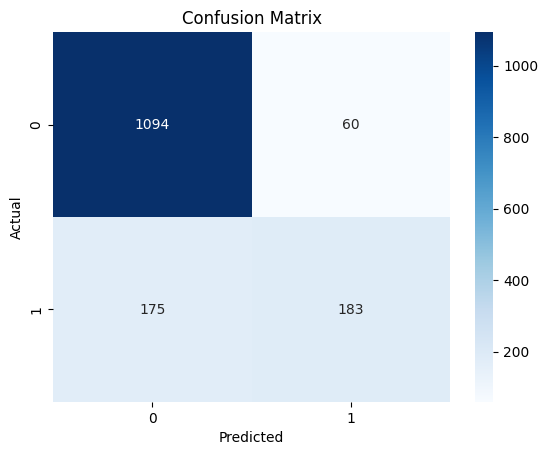

In [41]:
conf_matrix = confusion_matrix(y_test, y_pred)

import matplotlib.pyplot as plt

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Exercise 14. Extract the feature importances

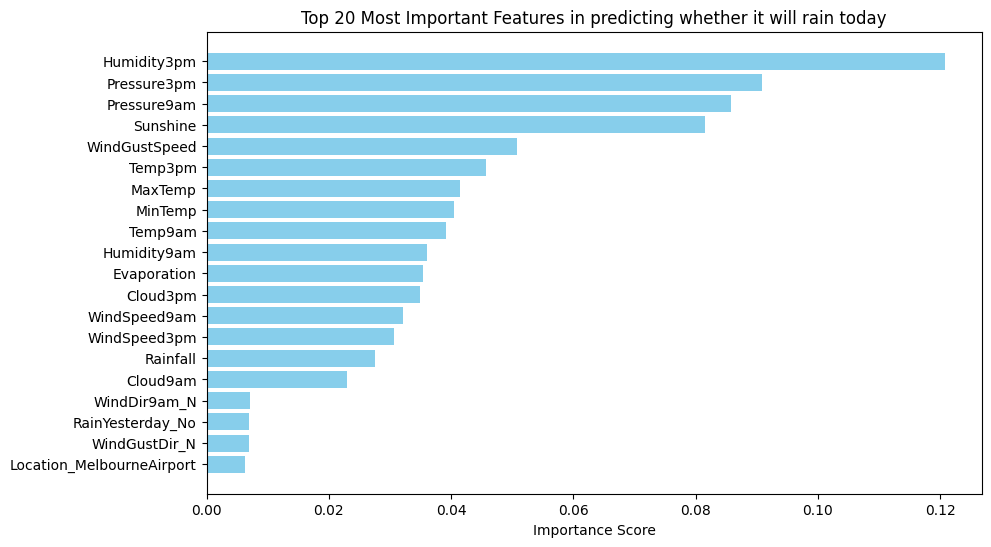

In [42]:
feature_importances = grid_search.best_estimator_["classifier"].feature_importances_

# Combine numeric and categorical feature names
feature_names = numeric_features + list(grid_search.best_estimator_["preprocessor"]
                                       .named_transformers_["cat"]
                                       .named_steps["onehot"]
                                       .get_feature_names_out(categorical_features))

N = 20 # Change this number to display more or fewer features

importance_df = pd.DataFrame({"Feature": feature_names,
                             "Importance": feature_importances
                             }).sort_values(by="Importance", ascending=False)

top_features = importance_df.head(N)
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top {N} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

### Exercise 15. Update the pipeline and the parameter grid

In [44]:
## Write your response
# Replace RandomForestClassifier with LogisticRegression

pipeline.set_params(classifier=LogisticRegression(random_state=42))

# update the model's estimator to use the new pipeline
grid_search.estimator = pipeline

# Define a new grid with Logistic Regression parameters
param_grid = {
    "classifier__solver": ["liblinear"],
    "classifier__penalty": ["l1", "l2"],
    "classifier__class_weight": [None, "balanced"]
}

grid_search.param_grid = param_grid

# Fit the updated pipeline with LogisticRegression
grid_search.fit(X_train, y_train)

# Make predictions
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.6s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.4s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=No

#### Compare the results to your previous model.

              precision    recall  f1-score   support

          No       0.86      0.93      0.89      1154
         Yes       0.69      0.51      0.59       358

    accuracy                           0.83      1512
   macro avg       0.77      0.72      0.74      1512
weighted avg       0.82      0.83      0.82      1512



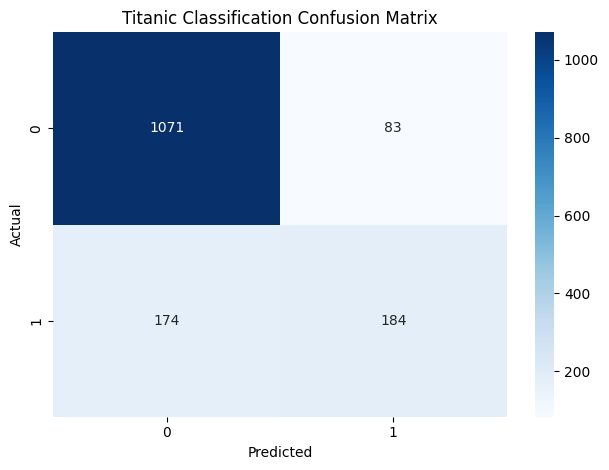

In [46]:
print(classification_report(y_test, y_pred))

# Generate the confusion matrix 
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()